In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.dataset import *
from utils.clustering import cluster_activations, get_cluster_df, get_cluster_embeddings
from utils.entropy import compute_entropies

from einops import rearrange
from torch_scatter import scatter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from icecream import ic
from tqdm.autonotebook import tqdm

from PyPDF2 import PdfMerger

In [4]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
seed_everything(42)

In [6]:
DEVICE = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

module_activation_dict = {
    # Conv blocks
    'audio_encoder.base.conv_block1': nn.Identity(),    # 0
    'audio_encoder.base.conv_block2': nn.Identity(),    # 1
    'audio_encoder.base.conv_block3': nn.Identity(),    # 2
    'audio_encoder.base.conv_block4': nn.Identity(),    # 3
    'audio_encoder.base.conv_block5': nn.Identity(),    # 4
    'audio_encoder.base.conv_block6': nn.Identity(),    # 5
    'audio_encoder.base.fc1': F.relu,                   # 6
    'audio_encoder.projection.linear1': F.gelu,         # 7
    'audio_encoder.projection.linear2': nn.Identity(),  # 8
}

module_list = list(module_activation_dict.keys())

In [7]:
# dataset = MedleySolosDBDataset(class_limit=200)
dataset = ESC50Dataset()

Using downloaded and verified file: /scratch/pratyaksh.g/esc50/ESC-50-master.zip


2000it [00:00, 11672.80it/s]

Loading audio files


In [8]:
class_indices = torch.tensor([dataset.class_to_idx[label] for label in dataset.class_label]).long()
num_classes = len(dataset.classes)

In [8]:
# cluster_activations(dataset, module_list)

In [40]:
layer_name = module_list[5]

In [31]:
activations = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/activations/{layer_name}.pt')
clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}.pt')
n_clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}_n.pt')

In [11]:
cluster_embeddings = get_cluster_embeddings(activations, clusters, n_clusters)

mega_neuron_activations = []
for cluster_embed in cluster_embeddings:
    mega_neuron_activations.append(rearrange(cluster_embed, 'c n -> n c'))

cluster_entropies = []
for mega_neuron_act in mega_neuron_activations:
    cluster_entropies.append(compute_entropies(mega_neuron_act, class_indices, num_classes))

In [13]:
# This threshold is the mean entropy of single neurons in the entire model
# (the layers of the model with a relu after it, at least)
threshold = 5.260542392730713

In [37]:
data_dict = dict(
    layer_name=[],
    partition_idx=[],
    cluster_idx=[],
    entropy=[],
    neuron_count=[],
    top_class_idx=[],
    top_class=[],
)

for partition_idx in reversed(range(0, len(n_clusters))):
    # argsort the entropies
    sorted_indices = torch.argsort(cluster_entropies[partition_idx], descending=False)

    # iterate through clusters, keeping track of the cluster's sorting rank/idx
    for sorting_idx, cluster_idx in tqdm(enumerate(sorted_indices), desc=f'Partition {partition_idx} / {len(n_clusters)}', total=len(sorted_indices)):
        # Just move on if it's a zero cluster
        current_cluster = cluster_embeddings[partition_idx][cluster_idx]

        zero = torch.zeros_like(current_cluster)
        if torch.all(torch.isclose(current_cluster, zero)):
            continue

        # If it's not a zero cluster, then plot it's cluster embedding
        num_neurons = (clusters[:, partition_idx] == cluster_idx).sum().item()
        df = pd.DataFrame({
            'dataset_index': range(len(dataset)),
            'activations': current_cluster,
            'classes': dataset.class_label
        })

        title = f'Layer: {layer_name}, Partition: {partition_idx}, Cluster: {cluster_idx}'
        title += ', '
        title += f'Entropy: {cluster_entropies[partition_idx][cluster_idx]:.2f}'
        title += ', '
        title += f'Neuron Count: {(clusters[:, partition_idx] == cluster_idx).sum().item()}'

        fig = px.bar(df, x='classes', y='activations', title=title,
                     labels = {
                         'classes': f'classes ({dataset.name})',
                         'activations': 'average cluster activations',
                     },
                     hover_data='dataset_index')

        file_dir = f'/scratch/pratyaksh.g/{dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'
        os.makedirs(file_dir, exist_ok=True)

        classwise = scatter(current_cluster, class_indices)
        top_class_idx = torch.argmax(classwise)
        top_class = dataset.classes[top_class_idx]

        data_dict['layer_name'].append(layer_name)
        data_dict['partition_idx'].append(partition_idx)
        data_dict['cluster_idx'].append(cluster_idx.item())
        data_dict['entropy'].append(cluster_entropies[partition_idx][cluster_idx].item())
        data_dict['neuron_count'].append((clusters[:, partition_idx] == cluster_idx).sum().item())
        data_dict['top_class_idx'].append(top_class_idx.item())
        data_dict['top_class'].append(top_class)

        ic(data_dict)

        break


        num_digits = len(str(n_clusters[partition_idx].item()))
        padded_sorting_idx = str(sorting_idx).zfill(num_digits)
        fig.write_image(f'{file_dir}/{padded_sorting_idx}-cluster-{cluster_idx}.pdf',
                        width=1920, height=1080, engine='kaleido')

Partition 4 / 5:   0%|          | 0/11 [00:00<?, ?it/s]

ic| data_dict: {'cluster_idx': [0],
                'entropy': [5.109516143798828],
                'layer_name': ['audio_encoder.base.conv_block5'],
                'neuron_count': [24526],
                'partition_idx': [4],
                'top_class': ['glass breaking'],
                'top_class_idx': [39]}


Partition 3 / 5:   0%|          | 0/62 [00:00<?, ?it/s]

ic| data_dict: {'cluster_idx': [0, 5],
                'entropy': [5.109516143798828, 4.776365756988525],
                'layer_name': ['audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5'],
                'neuron_count': [24526, 1658],
                'partition_idx': [4, 3],
                'top_class': ['glass breaking', 'glass breaking'],
                'top_class_idx': [39, 39]}


Partition 2 / 5:   0%|          | 0/921 [00:00<?, ?it/s]

ic| data_dict: {'cluster_idx': [0, 5, 585],
                'entropy': [5.109516143798828, 4.776365756988525, 4.453199863433838],
                'layer_name': ['audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5'],
                'neuron_count': [24526, 1658, 21],
                'partition_idx': [4, 3, 2],
                'top_class': ['glass breaking', 'glass breaking', 'fireworks'],
                'top_class_idx': [39, 39, 48]}


Partition 1 / 5:   0%|          | 0/2590 [00:00<?, ?it/s]

ic| data_dict: {'cluster_idx': [0, 5, 585, 25],
                'entropy': [5.109516143798828,
                            4.776365756988525,
                            4.453199863433838,
                            4.095354080200195],
                'layer_name': ['audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5'],
                'neuron_count': [24526, 1658, 21, 4],
                'partition_idx': [4, 3, 2, 1],
                'top_class': ['glass breaking',
                              'glass breaking',
                              'fireworks',
                              'glass breaking'],
                'top_class_idx': [39, 39, 48, 39]}


Partition 0 / 5:   0%|          | 0/10530 [00:00<?, ?it/s]

ic| data_dict: {'cluster_idx': [0, 5, 585, 25, 4349],
                'entropy': [5.109516143798828,
                            4.776365756988525,
                            4.453199863433838,
                            4.095354080200195,
                            3.9858648777008057],
                'layer_name': ['audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5',
                               'audio_encoder.base.conv_block5'],
                'neuron_count': [24526, 1658, 21, 4, 2],
                'partition_idx': [4, 3, 2, 1, 0],
                'top_class': ['glass breaking',
                              'glass breaking',
                              'fireworks',
                              'glass breaking',
                              'church bells'],
                'top_class_idx': [39, 39, 

In [27]:
for partition_idx in reversed(range(0, len(n_clusters))):
    # argsort the entropies
    sorted_indices = torch.argsort(cluster_entropies[partition_idx], descending=False)

    # iterate through clusters, keeping track of the cluster's sorting rank/idx
    for sorting_idx, cluster_idx in tqdm(enumerate(sorted_indices), desc=f'Partition {partition_idx} / {len(n_clusters)}', total=len(sorted_indices)):
        # Just move on if it's a zero cluster
        current_cluster = cluster_embeddings[partition_idx][cluster_idx]
        zero = torch.zeros_like(current_cluster)
        if torch.all(torch.isclose(current_cluster, zero)):
            continue

        # If it's not a zero cluster, then plot it's cluster embedding
        neurons_in_cluster = (clusters[:, partition_idx] == cluster_idx).nonzero().squeeze()
        n, c, w, h = activations.shape
        feature_map = torch.zeros((w, h))

        _, ts, fs = np.unravel_index(neurons_in_cluster.cpu().numpy(), (c, w, h))
        for t, f in zip(ts, fs):
            feature_map[t, f] += 1

        title = f'Layer: {layer_name}, Partition: {partition_idx}, Cluster: {cluster_idx}'
        title += ', '
        title += f'Semantic entropy: {cluster_entropies[partition_idx][cluster_idx]:.2f}'
        title += ', '
        title += f'Neuron Count: {(clusters[:, partition_idx] == cluster_idx).sum().item()}'

        fig = px.imshow(feature_map.cpu().numpy().T, origin='lower', color_continuous_scale='viridis', title=title)

        file_dir = f'/scratch/pratyaksh.g/{dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'
        os.makedirs(file_dir, exist_ok=True)

        num_digits = len(str(n_clusters[partition_idx].item()))
        padded_sorting_idx = str(sorting_idx).zfill(num_digits)
        fig.write_image(f'{file_dir}/{padded_sorting_idx}-posmap-{cluster_idx}.pdf',
                        width=1920, height=1080, engine='kaleido')

Partition 4 / 5:   0%|          | 0/11 [00:00<?, ?it/s]

Partition 3 / 5:   0%|          | 0/62 [00:00<?, ?it/s]

Partition 2 / 5:   0%|          | 0/921 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for partition_idx in reversed(range(0, len(n_clusters))):
    # argsort the entropies
    sorted_indices = torch.argsort(cluster_entropies[partition_idx], descending=False)

    # iterate through clusters, keeping track of the cluster's sorting rank/idx
    for sorting_idx, cluster_idx in tqdm(enumerate(sorted_indices), desc=f'Partition {partition_idx} / {len(n_clusters)}', total=len(sorted_indices)):
        # Just move on if it's a zero cluster
        current_cluster = cluster_embeddings[partition_idx][cluster_idx]
        zero = torch.zeros_like(current_cluster)
        if torch.all(torch.isclose(current_cluster, zero)):
            continue

        # If it's not a zero cluster, then plot it's cluster embedding
        num_neurons = (clusters[:, partition_idx] == cluster_idx).sum().item()
        df = pd.DataFrame({
            'dataset_index': range(len(dataset)),
            'activations': current_cluster,
            'classes': dataset.class_label
        })

        title = f'Layer: {layer_name}, Partition: {partition_idx}, Cluster: {cluster_idx}'
        title += ', '
        title += f'Entropy: {cluster_entropies[partition_idx][cluster_idx]:.2f}'
        title += ', '
        title += f'Neuron Count: {(clusters[:, partition_idx] == cluster_idx).sum().item()}'

        fig = px.bar(df, x='classes', y='activations', title=title,
                     labels = {
                         'classes': f'classes ({dataset.name})',
                         'activations': 'average cluster activations',
                     },
                     hover_data='dataset_index')

        file_dir = f'/scratch/pratyaksh.g/{dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'
        os.makedirs(file_dir, exist_ok=True)

        num_digits = len(str(n_clusters[partition_idx].item()))
        padded_sorting_idx = str(sorting_idx).zfill(num_digits)
        fig.write_image(f'{file_dir}/{padded_sorting_idx}-cluster-{cluster_idx}.pdf',
                        width=1920, height=1080, engine='kaleido')

Partition 3 / 5:   0%|          | 0/62 [00:00<?, ?it/s]

In [50]:
layer_name = module_list[6]
layer_name

'audio_encoder.base.fc1'

In [51]:
activations = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/activations/{layer_name}.pt')
clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}.pt')
n_clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}_n.pt')

In [52]:
for partition_idx in tqdm(reversed(range(0, len(n_clusters))), total=len(n_clusters)):
    merger = PdfMerger()
    file_dir = f'/scratch/pratyaksh.g/{dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}/'

    for file in sorted(os.listdir(file_dir)):
        if file.endswith('.pdf'):
            merger.append(open(file_dir + file, 'rb'))

    merger.write(open(f'/scratch/pratyaksh.g/{dataset.path_name}/cluster-plots/{layer_name}/partition-{partition_idx}-merged.pdf', 'wb'))

  0%|          | 0/3 [00:00<?, ?it/s]

In [76]:
df = pd.read_csv(f'/scratch/pratyaksh.g/esc50/cluster-stats/{layer_name}.csv')

In [79]:
df[df['entropy'] < 5.00]

,layer_name,partition_idx,cluster_idx,entropy,neuron_count,top_class_idx,top_class
11,audio_encoder.base.conv_block5,3,5,4.776366,1658,39,glass breaking
12,audio_encoder.base.conv_block5,3,6,4.855853,9526,39,glass breaking
73,audio_encoder.base.conv_block5,2,585,4.453200,21,48,fireworks
74,audio_encoder.base.conv_block5,2,586,4.458529,21,48,fireworks
75,audio_encoder.base.conv_block5,2,347,4.615161,15,49,hand saw
...,...,...,...,...,...,...,...
168,audio_encoder.base.conv_block5,2,573,4.991540,12,18,toilet flush
169,audio_encoder.base.conv_block5,2,897,4.993539,21,27,brushing teeth
170,audio_encoder.base.conv_block5,2,791,4.994584,21,27,brushing teeth
171,audio_encoder.base.conv_block5,2,436,4.995130,21,44,engine


In [ ]:
###

In [ ]:
clusters_to_plot = [
    # from top to bottom in the figure
    # layer, partition, cluster
    (1, 5, 13),
    (3, 4, 6),
    (6, 1, 19),
]

In [ ]:
cluster_class_act = []
for cluster_to_plot in clusters_to_plot:
    layer_idx, partition_idx, cluster_idx = cluster_to_plot

    layer_name = module_list[layer_idx]
    activations = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/activations/{layer_name}.pt')
    clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}.pt')
    n_clusters = torch.load(f'/scratch/pratyaksh.g/{dataset.path_name}/clusters/{layer_name}_n.pt')

    cluster_embeddings = get_cluster_embeddings(activations, clusters, n_clusters)
    cluster_embedding = cluster_embeddings[partition_idx][cluster_idx]

    classwise = scatter(cluster_embedding, class_indices)
    cluster_class_act.append(classwise)

In [ ]:
dataframes = [
    pd.DataFrame({
        'class': dataset.classes,
        'activation': cluster_class_act[i].cpu().numpy()
    })
    for i in range(len(clusters_to_plot))
]

In [ ]:
layer_short_names = [f'conv{i}' for i in range(1, 7)] + ['fc1']

In [ ]:
sns.color_palette('muted', 5)
palette = [color for color in sns.color_palette('muted', 5) for _ in range(10)]

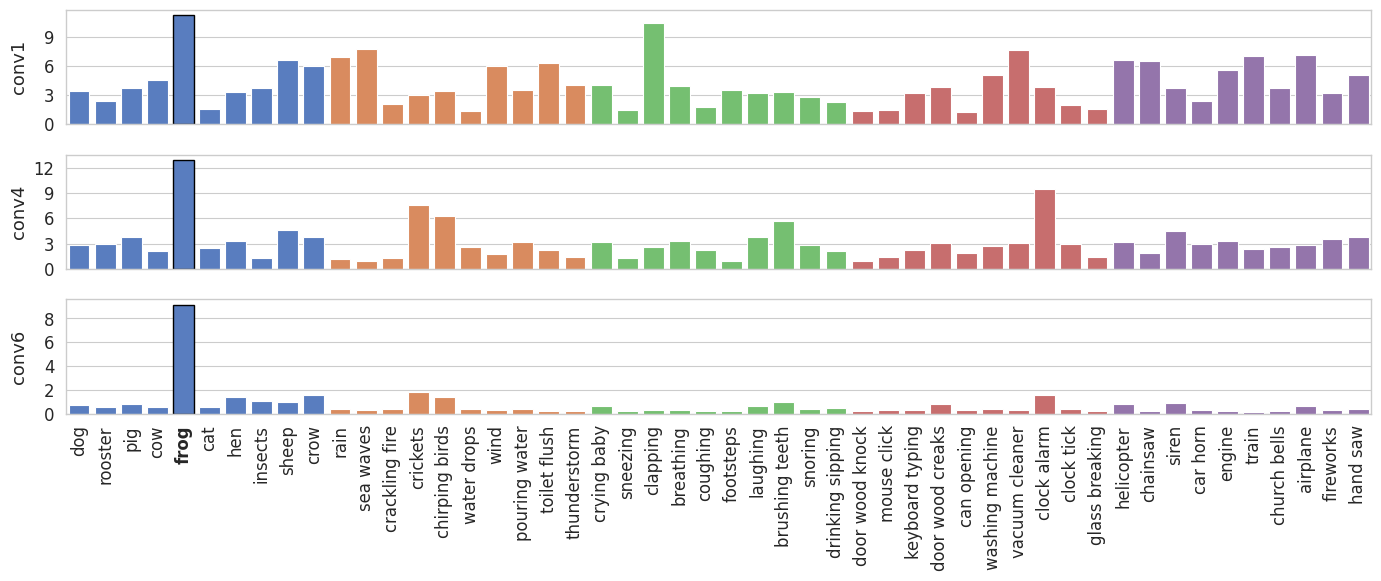

In [ ]:
sns.set_theme('paper', style='whitegrid', font_scale=1.35, rc={'figure.figsize': (14, 6)})
fig, axs = plt.subplots(3, 1, sharex=True)

highlighted_class = 'frog'
for i, df in enumerate(dataframes):
    l, p, c = clusters_to_plot[i]
    plt.subplot(3, 1, i+1)
    sns.barplot(x='class', y='activation', data=df, palette=palette)
    plt.xlabel('')
    plt.ylabel('')
    plt.ylabel(layer_short_names[l])
    # plt.text(-3, 2, f'{layer_short_names[l]}, p{p}, c{c}', rotation=90, ha='center', va='center')
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(5, integer=True))


# iterate through the axes and bold the label for the highlighted class
for ax in plt.gcf().axes:
    for label in ax.get_xticklabels():
        if label.get_text() == highlighted_class:
            label.set_fontweight('bold')

    for idx, bar in enumerate(ax.patches):
        if dataset.classes[idx] == highlighted_class:
            bar.set_edgecolor('black')
            bar.set_linewidth(1)

# iterate through the bars and add lighter borders to the highlighted class
fig.align_ylabels()
plt.xticks(rotation=90)
plt.tight_layout()

# plt.savefig('/scratch/pratyaksh.g/paper-plots/cluster-clarity-w-layers-4.pdf')